# TimeGAN: Generate Synthetic Data

Neural Networks in TimeGAN:

1. Generator
1. Discriminator
1. Embedder
1. Recovery Network

_TimeGAN_ is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

Research paper: [Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html) by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar.

- [Kaggle Reference](https://www.kaggle.com/code/alincijov/stocks-generate-synthetic-data-timegan/notebook)

- [Tutorial](https://towardsdatascience.com/synthetic-time-series-data-a-gan-approach-869a984f2239)

- [Google Colab](https://colab.research.google.com/github/ydataai/ydata-synthetic/blob/master/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb#scrollTo=zIytrOt2yQzs)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow import function, GradientTape, sqrt, abs, reduce_mean, ones_like, zeros_like, convert_to_tensor,float32
from tensorflow import data as tfdata
from tensorflow import config as tfconfig
from tensorflow import nn
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-06-28 15:59:00.942366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 15:59:00.977578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 15:59:00.977828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 15:59:00.978836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
data = pd.read_csv("yahoo_stock.csv")

In [6]:
data.shape

(1825, 7)

In [7]:
data.isna().values.any()

False

In [8]:
data.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [10]:
data.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

In [11]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [12]:
data['Date'].min(), data['Date'].max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [13]:
# Define TimeGAN parameters-
seq_len = 24
n_seq = 6
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 5000

In [14]:
gan_args = batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim

In [15]:
def preprocess(data, seq_len):
    ori_data = data[::-1]
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)
    
    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)
        
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
        
    return data


In [16]:
# Preprocess given data-
stock_data = preprocess(data = data.iloc[:, 1:].values, seq_len = seq_len)

In [17]:
type(stock_data), len(stock_data)

(list, 1801)

In [18]:
stock_data[10].shape, stock_data[1000].shape

((24, 6), (24, 6))

In [19]:
def net(
    model, n_layers,
    hidden_units, output_units,
    net_type = 'GRU'):
    if net_type == 'GRU':
        for i in range(n_layers):
            model.add(
                GRU(
                    units = hidden_units, return_sequences = True,
                    name = f'GRU_{i + 1}'
                )
            )
    else:
        for i in range(n_layers):
            model.add(
                LSTM(
                    units = hidden_units, return_sequences = True,
                    name = f'LSTM_{i + 1}'
                )
            )

    model.add(
        Dense(
            units = output_units, activation = 'sigmoid',
            name = 'OUT'
        )
    )
    
    return model


In [20]:
class Generator(Model):
    def __init__(self, hidden_dim, net_type = 'GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name = 'Generator')
        model = net(
            model, n_layers = 3,
            hidden_units = self.hidden_dim,
            output_units = self.hidden_dim,
            net_type = self.net_type
        )
        
        return model
    

In [21]:
class Discriminator(Model):
    def __init__(self, hidden_dim, net_type = 'GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name = 'Discriminator')
        model = net(
            model, n_layers = 3,
            hidden_units = self.hidden_dim,
            output_units = 1, net_type = self.net_type
        )
        
        return model


In [22]:
class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim = hidden_dim
        self.n_seq = n_seq
        return

    def build(self, input_shape):
        recovery = Sequential(name = 'Recovery')
        recovery = net(
            recovery, n_layers = 3,
            hidden_units = self.hidden_dim,
            output_units = self.n_seq
        )
        return recovery
    

In [23]:
class Embedder(Model):

    def __init__(self, hidden_dim):
        self.hidden_dim = hidden_dim
        return

    def build(self, input_shape):
        embedder = Sequential(name = 'Embedder')
        embedder = net(
            embedder, n_layers = 3,
            hidden_units = self.hidden_dim,
            output_units = self.hidden_dim
        )
        return embedder
    

In [24]:
class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim = hidden_dim

    def build(self, input_shape):
        model = Sequential(name = 'Supervisor')
        model = net(
            model, n_layers = 2,
            hidden_units = self.hidden_dim,
            output_units = self.hidden_dim
        )
        
        return model
    

In [25]:
class TimeGAN():
    def __init__(
        self, model_parameters,
        hidden_dim, seq_len,
        n_seq, gamma
    ):
        self.seq_len = seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq = n_seq
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.define_gan()

    def define_gan(self):
        self.generator_aux = Generator(self.hidden_dim).build(input_shape = (self.seq_len, self.n_seq))
        self.supervisor = Supervisor(self.hidden_dim).build(input_shape = (self.hidden_dim, self.hidden_dim))
        self.discriminator = Discriminator(self.hidden_dim).build(input_shape = (self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape = (self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape = (self.seq_len, self.n_seq))

        X = Input(shape = [self.seq_len, self.n_seq], batch_size = self.batch_size, name = 'RealData')
        Z = Input(shape = [self.seq_len, self.n_seq], batch_size = self.batch_size, name = 'RandomNoise')

        # AutoEncoder-
        H = self.embedder(X)
        X_tilde = self.recovery(H)
        
        self.autoencoder = Model(inputs = X, outputs = X_tilde)

        # Adversarial Supervise Architecture-
        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = Model(
            inputs = Z, outputs = Y_fake,
            name = 'AdversarialSupervised'
        )
        
        # Adversarial architecture in latent space-
        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = Model(
            inputs = Z, outputs = Y_fake_e,
            name = 'AdversarialEmbedded'
        )
        
        #Synthetic data generation-
        X_hat = self.recovery(H_hat)
        
        self.generator = Model(
            inputs = Z, outputs = X_hat,
            name = 'FinalGenerator'
        )

        
        # Final discriminator model-
        Y_real = self.discriminator(H)
        
        self.discriminator_model = Model(
            inputs = X, outputs = Y_real,
            name = "RealDiscriminator"
        )

        # Loss functions-
        self._mse = MeanSquaredError()
        self._bce = BinaryCrossentropy()
        

In [26]:
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)
    
    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())

    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))
    

In [27]:
# Initialize TimeGAN model-
synth = TimeGAN(
    model_parameters = gan_args, hidden_dim = 24,
    seq_len = seq_len, n_seq = n_seq,
    gamma = 1
)

2022-06-28 15:59:27.998768: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 15:59:28.001474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 15:59:28.001836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 15:59:28.002114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [28]:
# Specify optimizer-
autoencoder_opt = Adam(learning_rate = learning_rate)

# Train TimeGAN model-
for _ in tqdm(range(train_steps), desc = 'Emddeding network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows = len(stock_data)))
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)

Emddeding network training:   0%|                                           | 0/5000 [00:00<?, ?it/s]2022-06-28 15:59:38.645450: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-06-28 15:59:38.751105: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Emddeding network training: 100%|████████████████████████████████| 5000/5000 [03:37<00:00, 23.00it/s]


In [29]:
supervisor_opt = Adam(learning_rate = learning_rate)

for _ in tqdm(range(train_steps), desc = 'Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows = len(stock_data)))
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)

Supervised network training: 100%|███████████████████████████████| 5000/5000 [03:18<00:00, 25.19it/s]


In [31]:
# Specify GD optimizers for different TimeGAN networks-
generator_opt = Adam(learning_rate = learning_rate)
embedder_opt = Adam(learning_rate = learning_rate)
discriminator_opt = Adam(learning_rate = learning_rate)

In [32]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0

for _ in tqdm(range(train_steps), desc = 'Joint networks training'):

    # Train the generator (k times as often as the discriminator)
    # Here, k = 2-
    for _ in range(2):
        X_ = next(synth.get_batch_data(stock_data, n_windows = len(stock_data)))
        Z_ = next(synth.get_batch_noise())
        
        # Train the generator-
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        # Train the embedder-
        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(synth.get_batch_data(stock_data, n_windows = len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_d_loss = synth.discriminator_loss(X_, Z_)
    
    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)
        

Joint networks training: 100%|███████████████████████████████████| 5000/5000 [29:35<00:00,  2.82it/s]


In [49]:
'''
synth.discriminator.save("Trained_Discriminator_yahoo.pkl")
synth.generator.save("Trained_Generator_yahoo.pkl")
synth.recovery.save("Trained_Recovery_yahoo.pkl")
synth.embedder.save("Trained_Embedder_yahoo.pkl")
'''
synth.discriminator.save_weights("Trained_Discriminator_yahoo.h5", overwrite = True)
synth.generator.save_weights("Trained_Generator_yahoo.h5", overwrite = True)
synth.recovery.save_weights("Trained_Recovery_yahoo.h5", overwrite = True)
synth.embedder.save_weights("Trained_Embedder_yahoo.h5", overwrite = True)

In [33]:
# Generate time-series data using trained TimeGAN-
sample_size = 500
idx = np.random.permutation(len(stock_data))[:sample_size]

In [50]:
real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

Synthetic data generation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.51it/s]


In [52]:
real_sample.shape, synth_data.shape, synthetic_sample.shape

((500, 24, 6), (1920, 24, 6), (500, 24, 6))

In [54]:
# synth_data_reshaped = real_sample.reshape(-1, seq_len)
# stock_data_reshaped = np.asarray(synthetic_sample).reshape(-1,seq_len)
# real_sample_reshaped = real_sample.reshape(-1, seq_len)

real_sample_reshaped = real_sample.reshape(500 * 24, 6)
synth_data_reshaped = synth_data.reshape(1920 * 24, 6)
synthetic_sample_reshaped = synthetic_sample.reshape(500 * 24, 6)

In [55]:
synth_data_reshaped.shape, synthetic_sample_reshaped.shape, real_sample_reshaped.shape

((46080, 6), (12000, 6), (12000, 6))

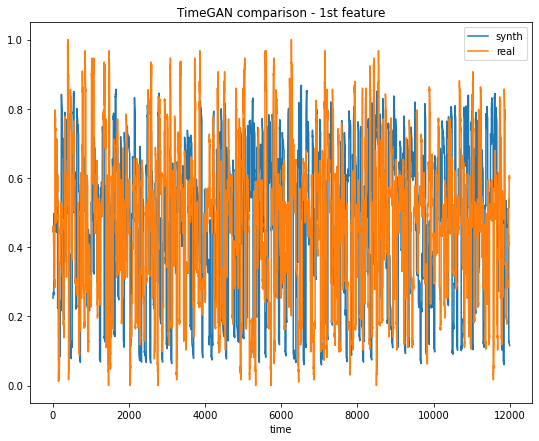

In [57]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:12000, 0], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 0], label = 'synth sample')
plt.plot(real_sample_reshaped[:, 0], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN comparison - 1st feature")
plt.show()

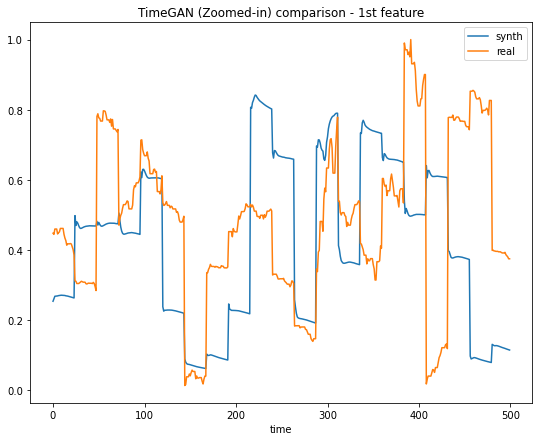

In [63]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:500, 0], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 0], label = 'synth sample')
plt.plot(real_sample_reshaped[:500, 0], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN (Zoomed-in) comparison - 1st feature")
plt.show()

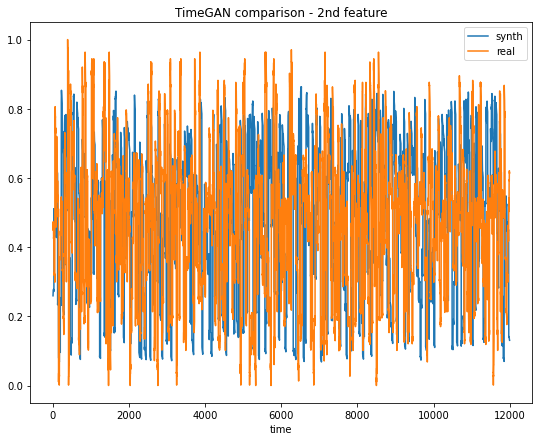

In [58]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:12000, 1], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 1], label = 'synth sample')
plt.plot(real_sample_reshaped[:, 1], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN comparison - 2nd feature")
plt.show()

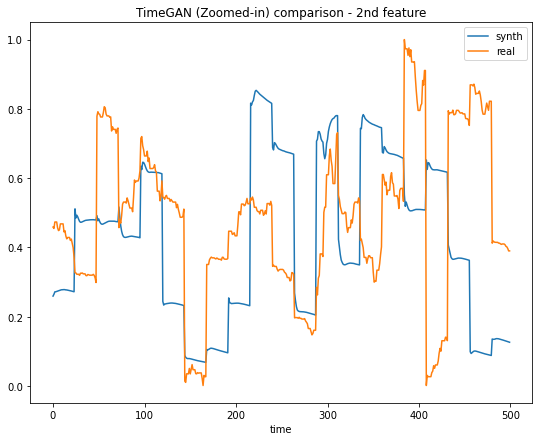

In [65]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:500, 1], label = 'synth')
plt.plot(real_sample_reshaped[:500, 1], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN (Zoomed-in) comparison - 2nd feature")
plt.show()

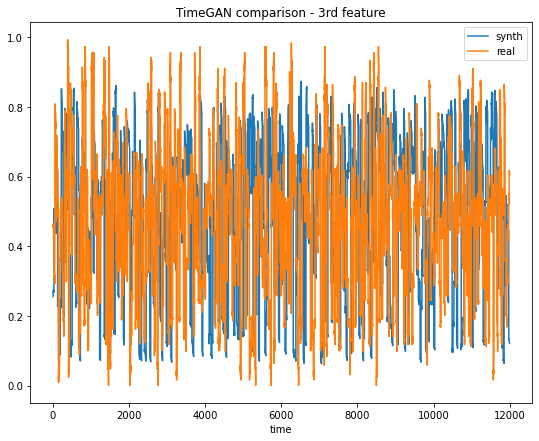

In [59]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:12000, 2], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 2], label = 'synth sample')
plt.plot(real_sample_reshaped[:, 2], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN comparison - 3rd feature")
plt.show()

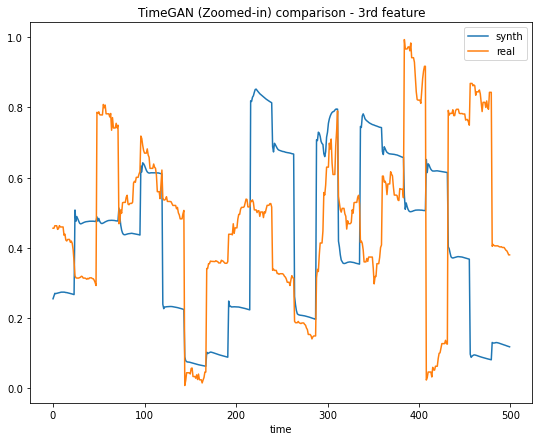

In [66]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:500, 2], label = 'synth')
plt.plot(real_sample_reshaped[:500, 2], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN (Zoomed-in) comparison - 3rd feature")
plt.show()

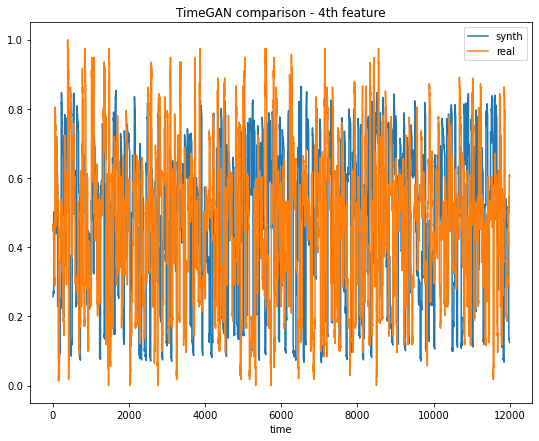

In [60]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:12000, 3], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 3], label = 'synth sample')
plt.plot(real_sample_reshaped[:, 3], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN comparison - 4th feature")
plt.show()

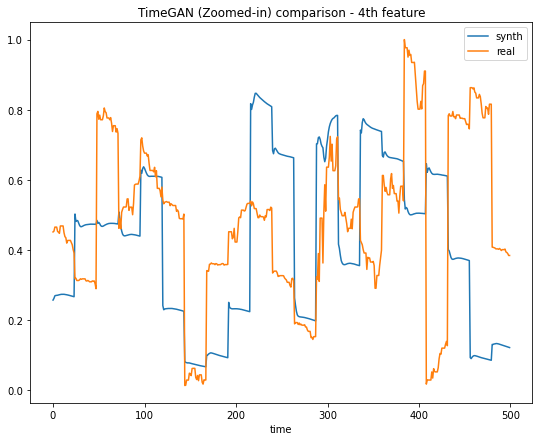

In [67]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:500, 3], label = 'synth')
plt.plot(real_sample_reshaped[:500, 3], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN (Zoomed-in) comparison - 4th feature")
plt.show()

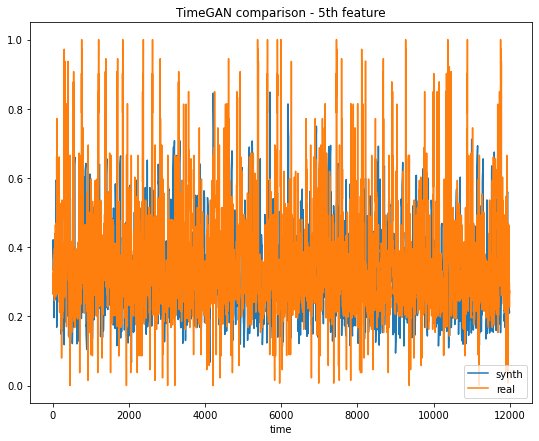

In [61]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:12000, 4], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 4], label = 'synth sample')
plt.plot(real_sample_reshaped[:, 4], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN comparison - 5th feature")
plt.show()

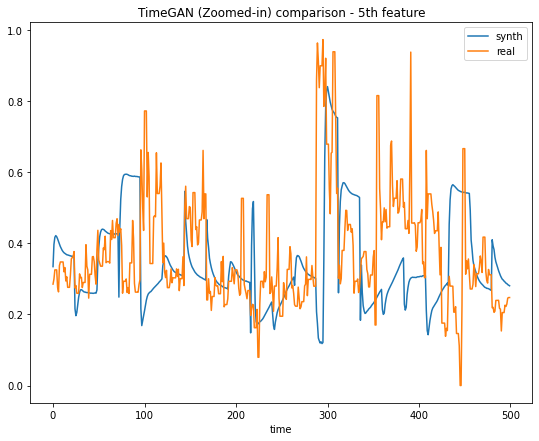

In [68]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:500, 4], label = 'synth')
plt.plot(real_sample_reshaped[:500, 4], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN (Zoomed-in) comparison - 5th feature")
plt.show()

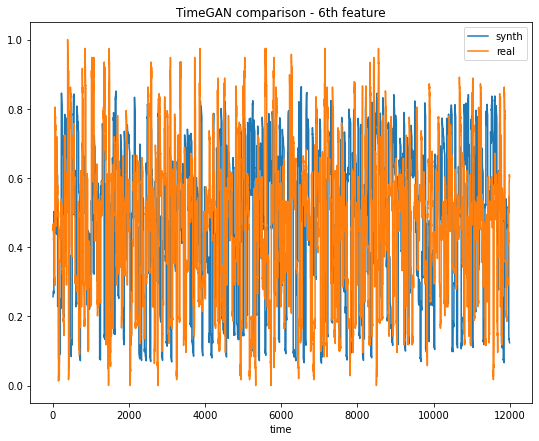

In [62]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:12000, 5], label = 'synth')
# plt.plot(synthetic_sample_reshaped[:, 5], label = 'synth sample')
plt.plot(real_sample_reshaped[:, 5], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN comparison - 6th feature")
plt.show()

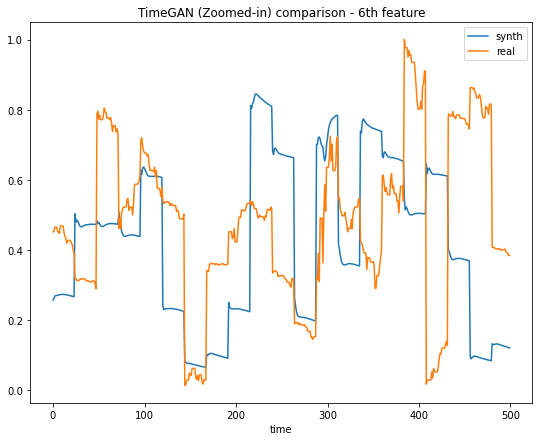

In [69]:
plt.figure(figsize = (9, 7))
plt.plot(synth_data_reshaped[:500, 5], label = 'synth')
plt.plot(real_sample_reshaped[:500, 5], label = 'real')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("TimeGAN (Zoomed-in) comparison - 6th feature")
plt.show()